In [ ]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from semantics.pipeline import Pipeline
from semantics.train import Trainer, TrainerConfig
import semantics.vision as sv

model_type = {
    0: 'SwinJSCC_w/o_SAandRA',
    1: 'SwinJSCC_w/_SA',
    2: 'SwinJSCC_w/_RA',
    3: 'SwinJSCC_w/_SAandRA',
}

batch_size = 128
img_size = 32
num_channels = 3
embed_dims = [64, 128]
depths = [2, 2]
num_heads = [4, 8]
snr = 10.0
rate = 16
model = model_type[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_cfg = {
    'img_size': (img_size, img_size),
    'patch_size': 2,
    'in_chans': num_channels,
    'embed_dims': embed_dims,
    'depths': depths,
    'num_heads': num_heads,
    'C': 32,
    'window_size': 4,
    'model': model,
    'snr': snr,
    'rate': rate,
}

decoder_cfg = {
    'img_size': (img_size, img_size),
    'embed_dims': list(reversed(embed_dims)),
    'depths': depths,
    'num_heads': list(reversed(num_heads)),
    'C': 32,
    'window_size': 4,
    'model': model,
    'snr': snr,
}


channel_cfg = {
    'mean': 0.0, 
    'std': 0.1, 
    'snr': snr, 
    'avg_power': None
}

# Encoder / Decoder / Channel
encoder = sv.SwinJSCCEncoder(**encoder_cfg).to(device)
decoder = sv.SwinJSCCDecoder(**decoder_cfg).to(device)
channel = sv.channels.AWGNChannel(**channel_cfg).to(device)

pipeline = Pipeline(encoder, channel, decoder).to(device)

# Data
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

train_ds = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
val_ds = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=pin)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=pin)

# Optimizer / Loss / Metrics
optimizer = AdamW(pipeline.parameters(), lr=3e-4)
criterion = torch.nn.L1Loss()
metrics = {
    'psnr': sv.PSNRMetric(),
    'ssim': sv.SSIMMetric(data_range=1.0, size_average=True, channel=3),
}

# Trainer
cfg = TrainerConfig(
    num_epochs=20,
    use_amp=True,
    amp_dtype="auto",
    grad_accum_steps=1,
    clip_grad_norm=1.0,
    compile_model=False,
)

trainer = Trainer(
    pipeline=pipeline,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=criterion,
    config=cfg,
    metrics=metrics,
)

trainer.train()

/home/jmadden2/anaconda3/envs/semantics/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jmadden2/anaconda3/envs/semantics/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[epoch 000] epoch=0.0000 train_loss=0.0631 val_loss=0.0364 val_psnr=26.0374 val_ssim=0.8629


[epoch 001] epoch=1.0000 train_loss=0.0322 val_loss=0.0311 val_psnr=27.8001 val_ssim=0.9080


[epoch 002] epoch=2.0000 train_loss=0.0267 val_loss=0.0253 val_psnr=29.3959 val_ssim=0.9239


[epoch 003] epoch=3.0000 train_loss=0.0249 val_loss=0.0243 val_psnr=29.7542 val_ssim=0.9298


[epoch 004] epoch=4.0000 train_loss=0.0240 val_loss=0.0227 val_psnr=30.2831 val_ssim=0.9326


[epoch 005] epoch=5.0000 train_loss=0.0232 val_loss=0.0223 val_psnr=30.4244 val_ssim=0.9352


[epoch 006] epoch=6.0000 train_loss=0.0227 val_loss=0.0237 val_psnr=30.0552 val_ssim=0.9469


[epoch 007] epoch=7.0000 train_loss=0.0222 val_loss=0.0214 val_psnr=30.8411 val_ssim=0.9403


[epoch 008] epoch=8.0000 train_loss=0.0218 val_loss=0.0221 val_psnr=30.6628 val_ssim=0.9415


[epoch 009] epoch=9.0000 train_loss=0.0213 val_loss=0.0212 val_psnr=30.9932 val_ssim=0.9401


[epoch 010] epoch=10.0000 train_loss=0.0212 val_loss=0.0210 val_psnr=31.0647 val_ssim=0.9455


[epoch 011] epoch=11.0000 train_loss=0.0206 val_loss=0.0205 val_psnr=31.2350 val_ssim=0.9465


[epoch 012] epoch=12.0000 train_loss=0.0203 val_loss=0.0203 val_psnr=31.3506 val_ssim=0.9420


[epoch 013] epoch=13.0000 train_loss=0.0201 val_loss=0.0228 val_psnr=30.5007 val_ssim=0.9524


[epoch 014] epoch=14.0000 train_loss=0.0197 val_loss=0.0194 val_psnr=31.7163 val_ssim=0.9465


[epoch 015] epoch=15.0000 train_loss=0.0195 val_loss=0.0192 val_psnr=31.8281 val_ssim=0.9487


[epoch 016] epoch=16.0000 train_loss=0.0190 val_loss=0.0189 val_psnr=31.9379 val_ssim=0.9491


[epoch 017] epoch=17.0000 train_loss=0.0188 val_loss=0.0185 val_psnr=32.1293 val_ssim=0.9487


[epoch 018] epoch=18.0000 train_loss=0.0187 val_loss=0.0188 val_psnr=32.0316 val_ssim=0.9502


[epoch 019] epoch=19.0000 train_loss=0.0185 val_loss=0.0186 val_psnr=32.1319 val_ssim=0.9539


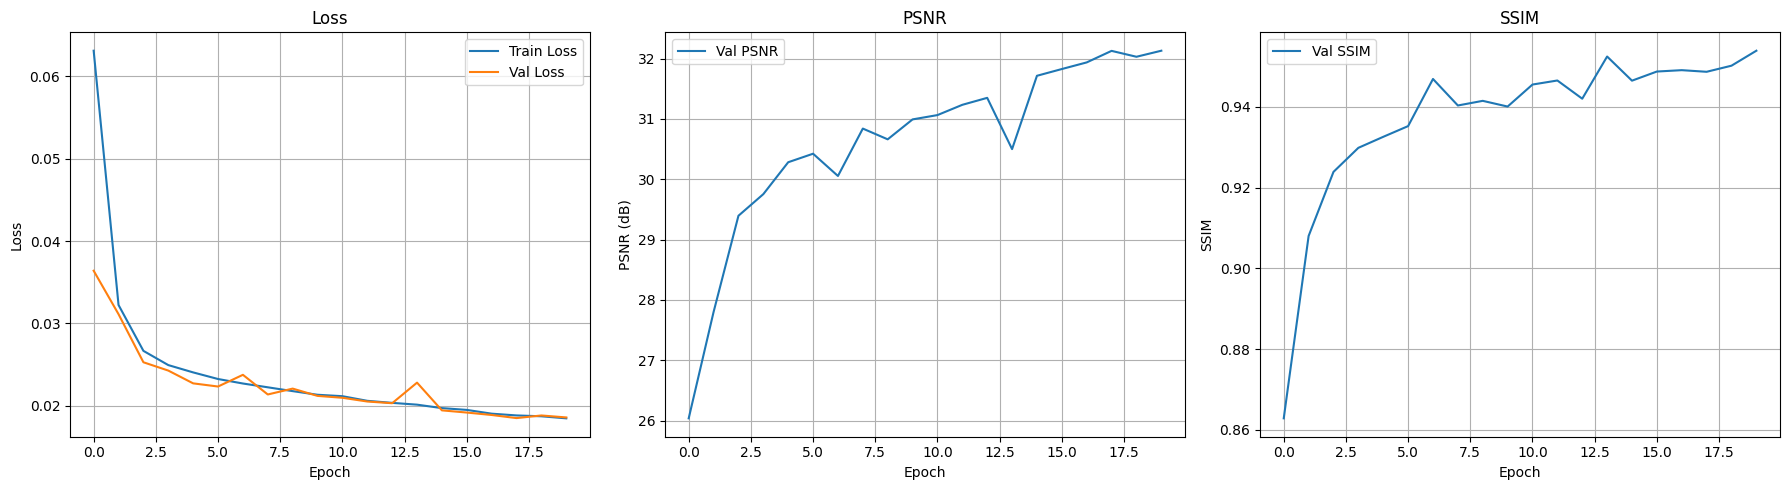

In [2]:
import matplotlib.pyplot as plt

history = trainer.history

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train & Val Loss
axes[0].plot(history["train_loss"], label="Train Loss")
axes[0].plot(history["val_loss"], label="Val Loss")
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid()

# PSNR
axes[1].plot(history["val_psnr"], label="Val PSNR")
axes[1].set_title("PSNR")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("PSNR (dB)")
axes[1].legend()
axes[1].grid()

# SSIM
axes[2].plot(history["val_ssim"], label="Val SSIM")
axes[2].set_title("SSIM")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("SSIM")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

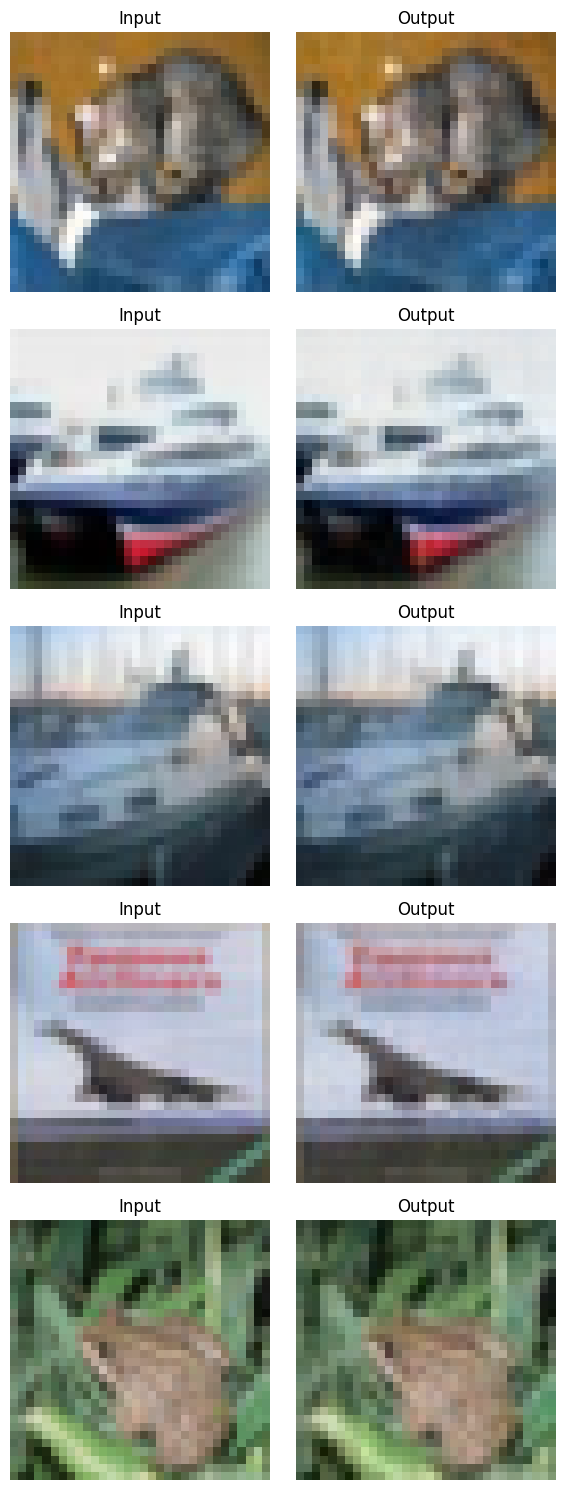

In [3]:
import numpy as np

# Get a batch of images from the validation loader
images, _ = next(iter(val_loader))
images = images.to(device)

# Pass images through the pipeline
ckpt_path = "checkpoints/best.pt"
trainer.load(ckpt_path)
pipeline = trainer.pipeline
with torch.no_grad():
    outputs, _ = pipeline(images)

# Move tensors to CPU and convert to numpy
inputs_np = images.cpu().numpy().clip(0, 1)
outputs_np = outputs.cpu().numpy().clip(0, 1)

# Visualize first 5 images: input and output side by side
fig, axes = plt.subplots(5, 2, figsize=(6, 15))
for i in range(5):
    # Input image
    axes[i, 0].imshow(np.transpose(inputs_np[i], (1, 2, 0)))
    axes[i, 0].set_title("Input")
    axes[i, 0].axis("off")
    # Output image
    axes[i, 1].imshow(np.transpose(outputs_np[i], (1, 2, 0)))
    axes[i, 1].set_title("Output")
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()